In [1]:
from pathlib import Path
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

from deep_learning.dataset.dataset import INBreast_Dataset_pytorch

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Plot different transformations

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(0)

def plot(imgs, original_img, **imshow_kwargs):
    num_cols = len(imgs[0])
    num_rows = len(imgs) + 1
    fig, axs = plt.subplots(
        figsize=(num_rows*3, num_cols*3), nrows=num_cols, ncols=num_rows, squeeze=False)
    for idx in range(num_cols):
        ax = axs[idx, 0]
        ax.set_title('Original image', fontsize=8)
        ax.imshow(np.asarray(original_img)[idx, 0, :, :], cmap='gray')
    for row_idx, tensor in enumerate(imgs, 1):
        for idx in range(tensor.shape[0]):
            ax = axs[idx, row_idx]
            ax.imshow(np.asarray(tensor)[idx, 0, :, :], **imshow_kwargs, cmap='gray')
        
    plt.tight_layout()

In [ ]:
_ = INBreast_Dataset_pytorch(
        lesion_types = ['calcification', 'cluster'],
        partitions = ['train', 'validation'],
        extract_patches = True,
        delete_previous = True,
        extract_patches_method = 'all',
        patch_size = 224,
        stride = 100,
        min_breast_fraction_roi = 0.7,
        n_jobs = -1,
        cropped_imgs = True,
        ignore_diameter_px = 15,
        neg_to_pos_ratio = None,
        seed = 1442
)

/home/jseia/Desktop/ml-dl/calc-det/deep_learning/dataset/dataset.py:36: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  super(INBreast_Dataset_pytorch, self).__init__(


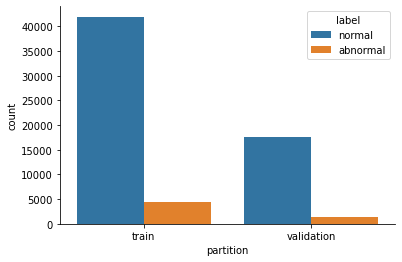

VALIDATION SET


normal      17648
abnormal     1302
Name: label, dtype: int64

neg/pos ratio val set: 0.07377606527651859
TRAIN SET


normal      41939
abnormal     4372
Name: label, dtype: int64

neg/pos ratio train set: 0.10424664393523927


In [20]:
import pandas as pd
import seaborn as sns

train_dataset = INBreast_Dataset_pytorch(
        lesion_types = ['calcification', 'cluster'],
        partitions = ['train'],
        extract_patches = False,
        delete_previous = False,
        extract_patches_method = 'all',
        patch_size = 224,
        stride = 100,
        min_breast_fraction_roi = 0.7,
        n_jobs = -1,
        cropped_imgs = True,
        ignore_diameter_px = 15,
        neg_to_pos_ratio = None,
        seed = 1442
)

val_dataset = INBreast_Dataset_pytorch(
        lesion_types = ['calcification', 'cluster'],
        partitions = ['validation'],
        extract_patches = False,
        delete_previous = False,
        extract_patches_method = 'all',
        patch_size = 224,
        stride = 100,
        min_breast_fraction_roi = 0.7,
        n_jobs = -1,
        cropped_imgs = True,
        ignore_diameter_px = 15,
        neg_to_pos_ratio = None,
        seed = 1442
)

train_val_df = pd.concat([train_dataset.df, val_dataset.df], ignore_index=True)
sns.countplot(data=train_val_df, x='partition', hue='label')
sns.despine()
plt.show()

print('VALIDATION SET')
display(val_dataset.df.label.value_counts())
print(f'neg/pos ratio val set: {val_dataset.df.label.value_counts()["abnormal"] / val_dataset.df.label.value_counts()["normal"]}')

print('TRAIN SET')
display(train_dataset.df.label.value_counts())
print(f'neg/pos ratio train set: {train_dataset.df.label.value_counts()["abnormal"] / train_dataset.df.label.value_counts()["normal"]}')

In [26]:
val_dataset.df.iloc[:,17].unique()

array(['normal', 'abnormal'], dtype=object)

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader

transforms = nn.Sequential(
    T.ColorJitter(brightness=0.6, contrast=0.6, saturation=0, hue=0),
    T.RandomAffine(
        degrees=(0, 20), translate=None, scale=None, shear=(1, 10, 1, 10),
        interpolation=T.InterpolationMode.BILINEAR, fill=0
    ),
    T.RandomPerspective(distortion_scale=0.2),
    T.RandomRotation(degrees=(0, 20)),
    T.RandomRotation(degrees=(90, 110)),
    T.RandomResizedCrop(size=(224, 224), scale=(0.9,1), ratio=(1,1)),
    T.RandomAutocontrast(),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip()
)

val_dataset = INBreast_Dataset_pytorch(
        lesion_types = ['calcification', 'cluster'],
        partitions = ['validation'],
        extract_patches = False,
        delete_previous = False,
        extract_patches_method = 'all',
        patch_size = 224,
        stride = 100,
        min_breast_fraction_roi = 0.7,
        n_jobs = -1,
        cropped_imgs = True,
        ignore_diameter_px = 15,
        neg_to_pos_ratio = None,
        seed = 1442
)

val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=4, pin_memory=True, drop_last=False)

transforms = nn.Sequential(
    T.RandomApply(transforms=transforms, p=0.5),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
)
np.random.seed(1442)
aug_seed = np.random.randint(1442)
torch.manual_seed(aug_seed)

for sample in val_dataloader:
    original_image = sample["img"]
    print(sample['label'])
    break

## Visualize transformations

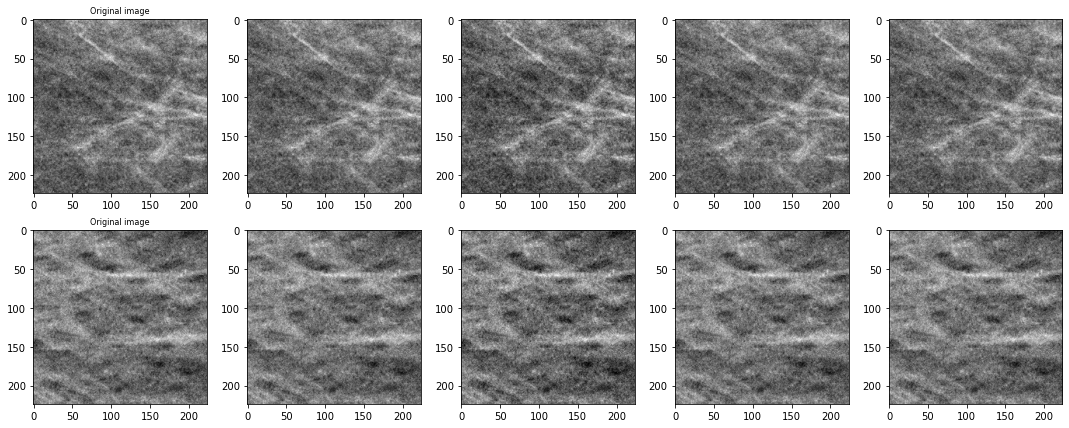

In [13]:
jitter = T.ColorJitter(brightness=0.6, contrast=0.6, saturation=0, hue=0)
jitted_imgs = [jitter(original_image) for _ in range(4)]
plot(jitted_imgs, original_image)

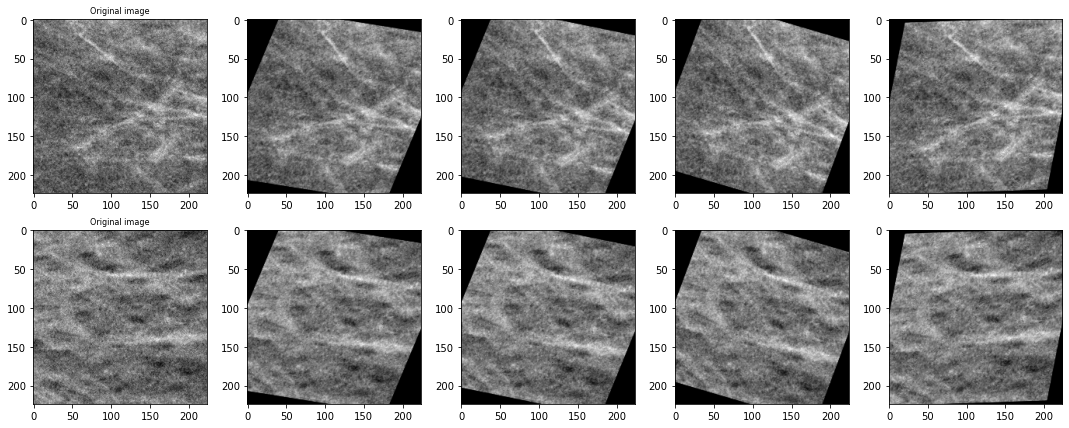

In [14]:
# mean = float(original_image.mean())
affine_transfomer = T.RandomAffine(
    degrees=(0, 20), translate=None, scale=None, shear=((1, 10, 1,10)),
    interpolation=T.InterpolationMode.BILINEAR, fill=0)
affine_imgs = [affine_transfomer(original_image) for _ in range(4)]
plot(affine_imgs, original_image)


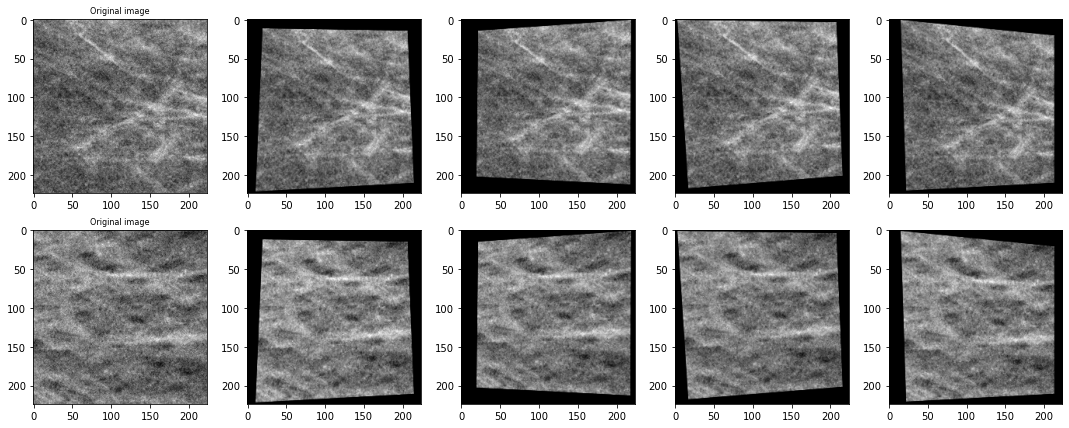

In [15]:
perspective_transformer = T.RandomPerspective(distortion_scale=0.2, p=1.0)
perspective_imgs = [perspective_transformer(original_image) for _ in range(4)]
plot(perspective_imgs, original_image)

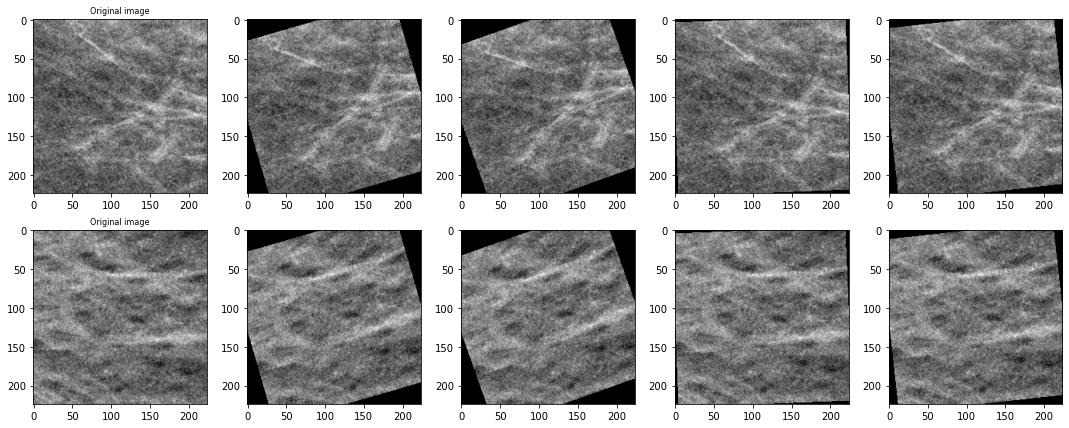

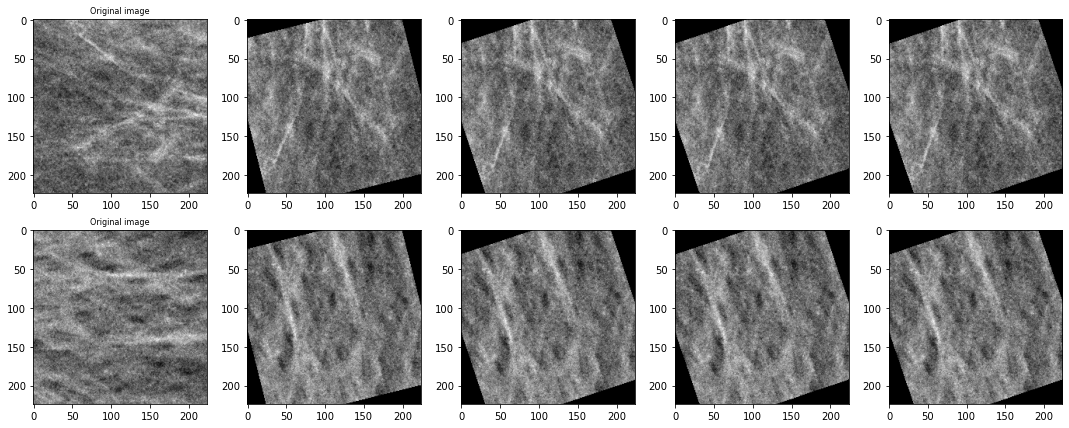

In [16]:
rotater = T.RandomRotation(degrees=(0, 20))
rotated_imgs = [rotater(original_image) for _ in range(4)]
plot(rotated_imgs, original_image)

rotater = T.RandomRotation(degrees=(90, 110))
rotated_imgs = [rotater(original_image) for _ in range(4)]
plot(rotated_imgs, original_image)

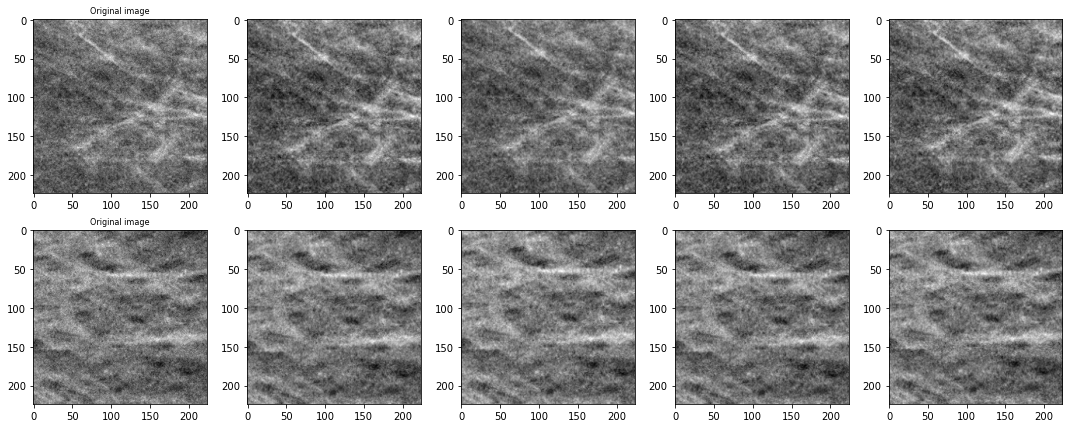

In [17]:
resize_cropper = T.RandomResizedCrop(size=(224, 224), scale=(0.9,1), ratio=(1,1))
resized_crops = [resize_cropper(original_image) for _ in range(4)]
plot(resized_crops, original_image)

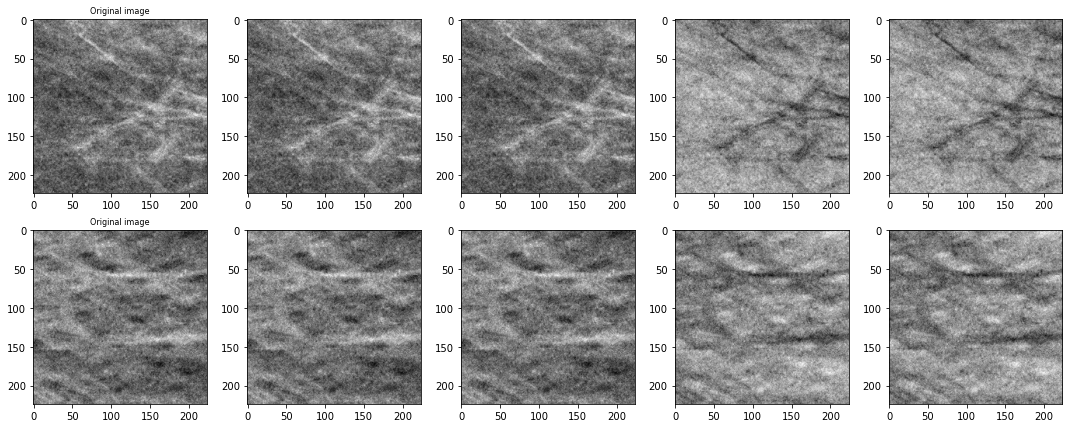

In [18]:
inverter = T.RandomInvert()
invertered_imgs = [inverter(original_image) for _ in range(4)]
plot(invertered_imgs, original_image)

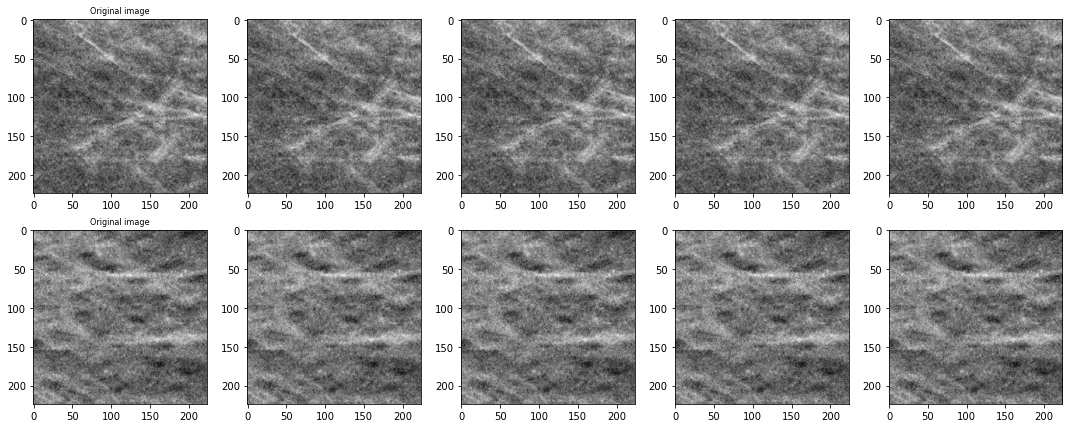

In [19]:
autocontraster = T.RandomAutocontrast()
autocontrasted_imgs = [autocontraster(original_image) for _ in range(4)]
plot(autocontrasted_imgs, original_image)

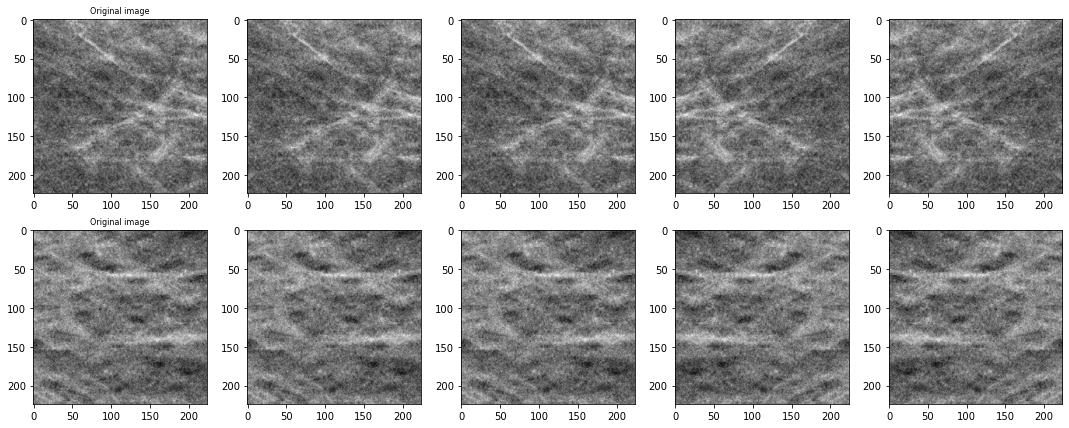

In [20]:
hflipper = T.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(original_image) for _ in range(4)]
plot(transformed_imgs, original_image)

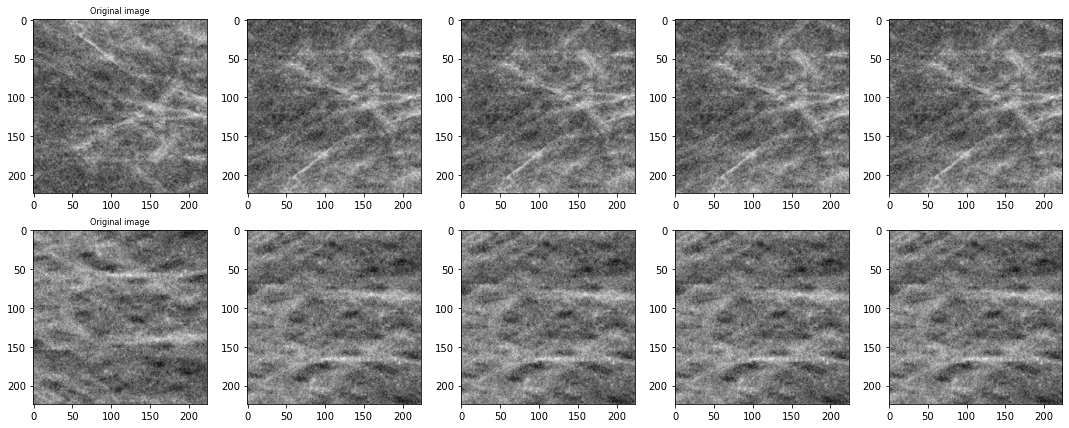

In [21]:
vflipper = T.RandomVerticalFlip(p=0.5)
transformed_imgs = [vflipper(original_image) for _ in range(4)]
plot(transformed_imgs, original_image)